In [1]:
import pandas as pd
import os

import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:

ecb_with_sentiment = pd.read_csv('./ecb_with_sentiment_bert.csv')
ecb_with_sentiment.head()

ecb_with_sentiment=ecb_with_sentiment.drop(columns=["contents"])
# ecb_with_sentiment = ecb_with_sentiment.loc[ecb_with_sentiment.subtitle.str.contains("\sMember\s"),:]

In [3]:
ecb_with_sentiment.to_csv('./ecb_sentiment_only_bert.csv')

In [4]:
ecb_with_sentiment.head()

,Unnamed: 0,date,speakers,title,subtitle,mean,std,pos_mean,pos_std,neu_mean,neu_std,neg_mean,neg_std,pos_np,neu_np,neg_np
0,0,2021-05-27,Isabel Schnabel,Societal responsibility and central bank indep...,"Keynote speech by Isabel Schnabel, Member of t...",-0.085368,0.387858,0.139730,0.144982,0.635173,0.270962,0.225097,0.301508,[0.21838163 0.03354283 0.02778754 0.03855713 0...,[0.76848191 0.91455883 0.28564495 0.55031949 0...,[0.01313641 0.05189829 0.68656749 0.41112337 0...
1,1,2021-05-27,Luis de Guindos,Climate change and financial integration,"Keynote speech by Luis de Guindos, Vice-Presid...",-0.026956,0.505761,0.202748,0.253906,0.567549,0.347908,0.229703,0.352064,[0.08870706 0.35806265 0.01477082 0.9309842 0...,[0.70682108 0.63062811 0.02607576 0.05536489 0...,[0.20447177 0.01130923 0.95915341 0.0136509 0...
2,3,2021-05-19,Fabio Panetta,At the edge of tomorrow: preparing the future ...,"Introductory remarks by Fabio Panetta, Member ...",0.316743,0.307511,0.381715,0.239636,0.553313,0.252128,0.064972,0.147106,[0.23331414 0.50757241 0.2567094 0.85213768 0...,[0.75631839 0.48265964 0.26314804 0.14051794 0...,[0.01036743 0.00976786 0.48014256 0.00734432 0...
3,4,2021-05-06,Christine Lagarde,Towards a green capital markets union for Europe,"Speech by Christine Lagarde, President of the ...",0.494729,0.233734,0.509391,0.228311,0.475947,0.223262,0.014662,0.010632,[0.60571969 0.07047932 0.67631507 0.56479281 0...,[0.38253784 0.90226835 0.31308943 0.40945569 0...,[0.01174252 0.02725238 0.01059556 0.02575157 0...
4,6,2021-04-29,Frank Elderson,All the way to zero: guiding banks towards a c...,"Keynote speech by Frank Elderson, Vice-Chair o...",0.221424,0.373454,0.308234,0.272779,0.604956,0.269417,0.086810,0.177816,[0.62994921 0.748299 0.10959322 0.38741919 0...,[0.35543764 0.24172987 0.79927289 0.59703314 0...,[0.01461315 0.00997107 0.09113391 0.01554759 0...


45
0.46078208012856664
0.9


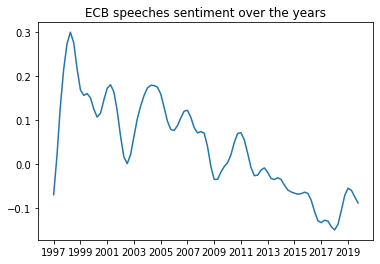

In [6]:

from scipy.ndimage.filters import gaussian_filter1d
# threshold_neutral = 0.6

#0.5 0.5 (no shift mean)
#0.6 0.6 (no shift mean)
threshold_significance = 0
threshold_mean_significance = 0
threshold_significance_fss = 0

for threshold_neutral in np.linspace(0.9,1,1):
    def remove_neutral(pos, neu, neg):
        pos = np.fromstring(pos[1:-1],sep=' ')
        neu = np.fromstring(neu[1:-1],sep=' ')
        neg = np.fromstring(neg[1:-1],sep=' ')
        combined = np.array([pos,neu,neg]).T #(num_of_sent,3)
        filtered = combined[neu<threshold_neutral]
        res = (filtered.T[0]-filtered.T[2]) 
        res = res[np.abs(res)>threshold_significance]
        return res

    def fss(pos, neg):
        pos = np.fromstring(pos[1:-1],sep=' ')
        neg = np.fromstring(neg[1:-1],sep=' ')
        combined = pos - neg
        filtered = combined[np.abs(combined)>=threshold_significance_fss]
        filtered = (np.heaviside(filtered, 0) -0.5) *2
        if len(filtered) == 0:
            return 0
        else:
            return filtered.mean()

    ecb_with_sentiment['filtered'] = ecb_with_sentiment.apply(lambda row: remove_neutral(row['pos_np'],row['neu_np'],row['neg_np']),axis=1)

    ecb_with_sentiment['filtered_mean'] = ecb_with_sentiment.apply(lambda row: row['filtered'].mean(),axis=1)

    ecb_with_sentiment['filtered_std'] = ecb_with_sentiment.apply(lambda row: row['filtered'].std(),axis=1)

    ecb_with_sentiment['fss'] = ecb_with_sentiment.apply(lambda row: fss(row['pos_np'], row['neg_np']),axis=1)
    


    old = len(ecb_with_sentiment)
    ecb_with_sentiment_new = ecb_with_sentiment[np.abs(ecb_with_sentiment.filtered_mean) > threshold_mean_significance]
    new = len(ecb_with_sentiment_new)
    print(old-new)

    # for each time interval (quarterly)
    #    check speech overal sentiment
    #    plot graph
    
    # quarters = ["({0})".format(i) for i in range(1,13)]
    quarters = ["(1|2|3)","(4|5|6)", "(7|8|9)","(10|11|12)"]
    # quarters = ["(1|2|3|4|5|6|7|8|9|10|11|12)"]
    # quarters = ["(1|2|3|4|5|6)","(7|8|9|10|11|12)"]

    col = ["year","quarter","mean","std",] # "fss_mean", "fss_std", "pos_mean", "pos_std", "neg_mean","neg_std"])

    quarterly_data = pd.DataFrame(columns = col) 


    for year in range(1997,2022):
        for index, quarter in enumerate(quarters):
            data = ecb_with_sentiment_new.loc[ecb_with_sentiment['date'].str.contains(str(year) + '-0?' + quarter + '-'), :]
            # assume sample mean (neglect difference in datapoints)
            temp_data = pd.DataFrame([[year, index + 1, data['fss'].mean(), (data['filtered_std']**2).mean()**0.5]],columns = col)
        
            quarterly_data = quarterly_data.append(temp_data, ignore_index = True)

    quarterly_data.to_csv('./ecb_sentiment_quarterly_bert.csv')


    year = [[ year + index/4 for index in range (0, 4) ]for year in range(1997,2022)]
    year = [item for sublist in year for item in sublist]
    # year = [ year for year in range(1997,2022)]
    mean = quarterly_data['mean'].to_numpy()
        
    mean = gaussian_filter1d(mean, sigma=1.5)
  
    shift = np.nan_to_num(mean).mean()

    # print(shift)
    # mean = mean - shift

    fig = plt.figure()



    x = year
    y = mean * 1
    # yerr = std
    
    # plt.errorbar(x, y, yerr = yerr)
    plt.plot(x,y)

    # plt.fill_between(x, y-yerr, y+yerr,
    #     alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    
    plt.xticks(np.arange(1997, 2021, 2))
    # plt.xlim(2000,2019)
    plt.title('ECB speeches sentiment over the years')
    print(threshold_neutral)
    plt.pause(0.1)
plt.show()
